In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import camera_calibration_show_extrinsics as show
from PIL import Image
from numpy.linalg import inv

In [2]:
# 這邊給定7*7方格，產生空陣列
corner_x = 7
corner_y = 7
objp = np.zeros((corner_x*corner_y,3), np.float32)

In [3]:
# 準備所有的角點
objp[:,:2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1,2)

In [4]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('data/*.jpg')

In [5]:
for idx, fname in enumerate(images[0:1]):
    print(idx, fname)

0 data\0000.jpg


Start finding chessboard corners...
find the chessboard corners of data\0000.jpg
find the chessboard corners of data\0001.jpg
find the chessboard corners of data\0002.jpg
find the chessboard corners of data\0003.jpg
find the chessboard corners of data\0004.jpg
find the chessboard corners of data\0005.jpg
find the chessboard corners of data\0006.jpg
find the chessboard corners of data\0007.jpg
find the chessboard corners of data\0008.jpg
find the chessboard corners of data\0009.jpg


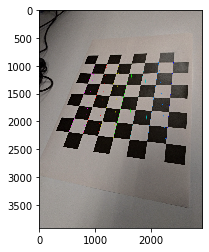

In [6]:
# Step through the list and search for chessboard corners
print('Start finding chessboard corners...')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), corners, ret)
        plt.imshow(img)

In [7]:

#######################################################################################################
#                                Homework 1 Camera Calibration                                        #
#               You need to implement camera calibration(02-camera p.76-80) here.                     #
#   DO NOT use the function directly, you need to write your own calibration function from scratch.   #
#                                          H I N T                                                    #
#                        1.Use the points in each images to find Hi                                   #
#                        2.Use Hi to find out the intrinsic matrix K                                  #
#                        3.Find out the extrensics matrix of each images.                             #
#######################################################################################################

In [8]:
# cv func
print('Camera calibration...')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

Camera calibration...


In [9]:
Vr = np.array(rvecs)
Tr = np.array(tvecs)
extrinsics = np.concatenate((Vr, Tr), axis=1).reshape(-1,6)

In [10]:
# def compute_view_homography(k):
#     N = len(imgpoints[k])
#     M = np.zeros((2*N, 9), dtype=np.float64)    
#     for i in range(N):
#         X, Y, Z = objpoints[k][i] # world
#         u, v = imgpoints[k][i][0] # img

#         row_1 = np.array([ -X, -Y, -1, 0, 0, 0, X*u, Y*u, u])
#         row_2 = np.array([ 0, 0, 0, -X, -Y, -1, X*v, Y*v, v])

#         M[2*i] = row_1
#         M[(2*i) + 1] = row_2 
#     u, s, vh = np.linalg.svd(M)
#     h = vh[np.argmin(s)].reshape(3, 3) # 最小的index
#     # 加上去rho
#     rho = np.sum([1 / h[2].dot(objpoint) for objpoint in objpoints[k]]) / (7*7)
#     h *= rho
    
#     return h

In [11]:
def compute_view_homography():
    num_img = 10
    corner_x = 7
    corner_y = 7
    H = np.zeros((num_img, 3, 3))
    H_ = np.zeros((num_img, 3, 3))
    for i in range(num_img):
        L = np.zeros((2*corner_x*corner_y, 9))

        # M is objpoints on same chessboard
        M = [coord for coord in objpoints[i]]
        M = np.array(M)
        M[:, 2] = 1
        u = imgpoints[i][:, 0, 0]
        v = imgpoints[i][:, 0, 1]

        # rewrite imgpoint = H * objpoint to Lx = 0, where x is [h1 h2 h3]. Here h1 h2 h3 are row vectors of H
        for j in range(corner_x*corner_y):
            L[j*2] = np.array([M[j, 0], M[j, 1], M[j, 2], 0, 0, 0, -u[j]*M[j, 0], -u[j]*M[j, 1], -u[j]*M[j, 2]])
            L[j*2+1] = np.array([0, 0, 0, M[j, 0], M[j, 1], M[j, 2], -v[j]*M[j, 0], -v[j]*M[j, 1], -v[j]*M[j, 2]])

        # x is nullspace of L
        u, w, vh = np.linalg.svd(L)
        x = vh[-1]
        H[i, 0] = x[0:3]
        H[i, 1] = x[3:6]
        H[i, 2] = x[6:9]

        # find rho
        # third row vector of H dot product objpoint and then multiply rho is equal to 1
        # use np.sum divide num_corners to compute mean value of rho
        rho = np.sum([1 / H[i, 2].dot(objpoint) for objpoint in M]) / (corner_x * corner_y)
        H[i] *= rho
    return H 

In [12]:
H_r = compute_view_homography()

In [13]:
def get_intrinsic_parameters(H_r):
        M = len(H_r) # 幾個h
        V = np.zeros((2*M, 6), np.float64) # product constraint for B
        for i in range(M):
            H = H_r[i]
            V[2*i] = v_pq(p=0, q=1, H=H)
            V[2*i + 1] = np.subtract(v_pq(p=0, q=0, H=H), v_pq(p=1, q=1, H=H))

        # solve V.b = 0
        u, s, vh = np.linalg.svd(V)
        b = vh[np.argmin(s)]
        return b

In [14]:
def v_pq(p, q, H):
            v = np.array([
                    H[0, p]*H[0, q],
                    H[0, p]*H[1, q] + H[1, p]*H[0, q],
                    H[1, p]*H[1, q],
                    H[2, p]*H[0, q] + H[0, p]*H[2, q],
                    H[2, p]*H[1, q] + H[1, p]*H[2, q],
                    H[2, p]*H[2, q]])
            return v

In [15]:
b = get_intrinsic_parameters(H_r)

In [16]:
b 

array([-6.18235709e-08, -9.44883932e-10, -6.41712191e-08,  9.14437039e-05,
        8.45790476e-05, -9.99999992e-01])

In [17]:
vc=(b[1]*b[3]-b[0]*b[4])/(b[0]*b[2]-b[1]**2)
l=b[5]-(b[3]**2+vc*(b[1]*b[2]-b[0]*b[4]))/b[0]
alpha=np.sqrt((l/b[0]))
beta=np.sqrt(((l*b[0])/(b[0]*b[2]-b[1]**2)))
gamma=-1*((b[1])*(alpha**2)*(beta/l))
uc=(gamma*vc/beta)-(b[3]*(alpha**2)/l)
K= np.array([
[alpha, gamma, uc],
[0, beta, vc],
[0, 0, 1.0],
])
K

array([[ 3.49478608e+03, -5.24325217e+01,  1.45929179e+03],
       [ 0.00000000e+00,  3.43064964e+03,  1.29653429e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [18]:
def get_extrinsic_parameters(i, H_r):
    la = 1 / np.linalg.norm(np.linalg.inv(K) * H_r[i][0, 0])
    r_1 = la * np.dot(np.linalg.inv(K), H_r[i][:, 0])
    r_2 = la * np.dot(np.linalg.inv(K), H_r[i][:, 1])
    r_3 = np.cross(r_1, r_2) # outer
    t = la * np.dot(np.linalg.inv(K), H_r[i][:, 2])
    return r_1, r_2, r_3, t

In [19]:
from scipy.spatial.transform import Rotation as R
def get_all_extrinsic(i):
    r1, r2, r3, tvec = get_extrinsic_parameters(i, H_r)
    r1 = r1.reshape(3, 1)
    r2 = r2.reshape(3, 1)
    r3 = r3.reshape(3, 1)
    tmp = np.concatenate([r1, r2], axis=1)
    res = np.concatenate([tmp, r3], axis=1)
    r = R.from_matrix(res)
    rvec = np.array(r.as_rotvec())
    res = np.concatenate((rvec, tvec)).reshape(-1,6)
    return res

In [20]:
extrinsic = []
for i in range(10):
    extrinsic.append(get_all_extrinsic(i)[0])
extrinsic = np.array(extrinsic)

In [21]:
extrinsic

array([[ 9.32710154e-04,  1.85879924e-03,  6.30382412e-02,
         4.62816953e-02, -1.62454441e-04,  1.86274891e-01],
       [-1.34572743e-04,  1.57215496e-04,  2.07154882e-03,
         6.86536200e-04, -1.00623590e-03,  8.94430152e-03],
       [-9.22676525e-05,  9.90743955e-05,  1.02765463e-03,
        -1.21033358e-04, -6.77286117e-04,  5.82170583e-03],
       [-2.84375624e-04,  1.96663867e-05,  1.50098830e-04,
        -1.04762879e-04, -8.66208699e-04,  3.49543007e-03],
       [-2.66593049e-04, -5.36728624e-04, -8.96451237e-04,
        -1.32036908e-03,  1.76682396e-03,  4.94829484e-03],
       [-4.58697561e-04,  3.45815870e-04,  5.62243333e-04,
        -1.78188552e-04, -2.53351387e-04,  6.76381730e-03],
       [-7.54710803e-05, -6.47989776e-05,  1.22674723e-04,
        -4.33156593e-04, -5.06032785e-04,  2.88932811e-03],
       [ 8.27694272e-05,  1.39928705e-03,  3.04706768e-03,
         1.64962306e-03,  1.28228459e-03,  1.71456647e-02],
       [-2.21092957e-04, -5.00691363e-05,  2.984

Show the camera extrinsics


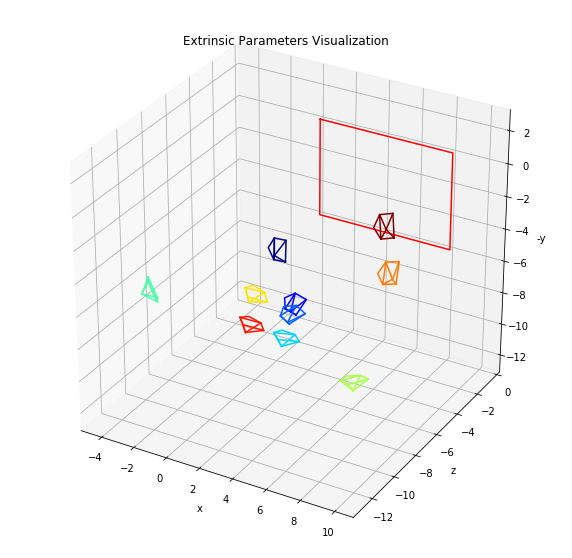

'\nfor angle in range(0, 360):\n    ax.view_init(30, angle)\n    plt.draw()\n    plt.pause(.001)\n'

In [22]:
# show the camera extrinsics
print('Show the camera extrinsics')
# plot setting
# You can modify it for better visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# camera setting
camera_matrix = mtx
cam_width = 0.064/0.1
cam_height = 0.032/0.1
scale_focal = 1600
# chess board setting
board_width = 8
board_height = 6
square_size = 1
# display
# True -> fix board, moving cameras
# False -> fix camera, moving boards
min_values, max_values = show.draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, extrinsics, board_width,
                                                board_height, square_size, True)

X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, 0)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization')
plt.show()

#animation for rotating plot
"""
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
"""